# Problem Description
The food inspection department conducts regular inspection on food quality for various restaurants in the city. It’s a very well documented procedure and over time some good amount of data has been generated out of these inspections. 

The inspection department would like to predict where they should focus most in terms of their next inspection schedule, so that they can most optimize their time at hand to catch the worst offenders. Can the past inspection or any data that they have collected predict which facility will pass or fail.

In this hackathon, MachineHack provides you with a subset of this dataset with information on food quality checks conducted on thousands of facilities that serve food across multiple cities. Your objective as a Data Scientist is to predict whether a facility will pass or fail the inspection based on a number of factors.

## Objective

Build a predictive model that is capable of predicting the outcome of an inspection conducted in a facility based on the given set of features

Features

    ID: A unique id for each inspection
    Date: The date at which the inspection was done in a particular facility
    LicenseNo: De-identified license number for a particular facility
    FacilityID: De-identified unique facility id  for a facility
    FacilityName: The encoded name of a facility
    Type: The type of the facility being inspected
    Street: The encoded street where the facility is located
    City: The encoded city where the facility is located
    State: The encoded state where the facility is located
    LocationID: An encoded location feature.
    Reason: The primary reason for the inspection
    SectionViolations: Laws violated by the facility
    RiskLevel: The level of risk the facility possesses to the consumers.
    Geo_Loc: De-identified geo location of the facility
    Inspection_Results: The result of the inspection

Target :
The inspection results can have any of the following values :

    0:’FACILITY CHANGED’
    1:’FAIL’
    2:’FURTHER INSPECTION REQUIRED’,
    3:’INSPECTION OVERRULED’
    4:’PASS’
    5:’PASS(CONDITIONAL)’
    6:’SHUT-DOWN’

## Evaluation
The leaderboard is evaluated using Multi Class Log loss (Cross-entropy loss) for the participant’s submission.

# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import skew, norm
import seaborn as sns
sns.set_style('darkgrid') 
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/Data_Train.xlsx
/kaggle/input/Sample_Submission.xlsx
/kaggle/input/Data_Test.xlsx


# Import datasets

In [2]:
train = pd.read_excel('/kaggle/input/Data_Train.xlsx')
test = pd.read_excel('/kaggle/input/Data_Test.xlsx')
sub = pd.read_excel('/kaggle/input/Sample_Submission.xlsx')

In [3]:
train.shape, test.shape, sub.shape

((147443, 15), (49148, 14), (49148, 7))

# Data exploration

In [4]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [5]:
train.head(2)

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results
0,31103489027986,26-04-2010,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33.0,High,locid16406,4
1,10088999935915,21-06-2009,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33.0,High,locid878,4


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147443 entries, 0 to 147442
Data columns (total 15 columns):
ID                    147443 non-null int64
Date                  147443 non-null object
LicenseNo             147443 non-null int64
FacilityID            147443 non-null int64
FacilityName          147443 non-null int64
Type                  143958 non-null object
Street                147443 non-null int64
City                  147443 non-null object
State                 147443 non-null object
LocationID            147408 non-null float64
Reason                147443 non-null object
SectionViolations     108375 non-null float64
RiskLevel             147443 non-null object
Geo_Loc               147443 non-null object
Inspection_Results    147443 non-null int64
dtypes: float64(2), int64(6), object(7)
memory usage: 16.9+ MB


In [7]:
train.isnull().sum()

ID                        0
Date                      0
LicenseNo                 0
FacilityID                0
FacilityName              0
Type                   3485
Street                    0
City                      0
State                     0
LocationID               35
Reason                    0
SectionViolations     39068
RiskLevel                 0
Geo_Loc                   0
Inspection_Results        0
dtype: int64

In [8]:
test.isnull().sum()

ID                       0
Date                     0
LicenseNo                0
FacilityID               0
FacilityName             0
Type                  1215
Street                   0
City                     0
State                    0
LocationID              15
Reason                   0
SectionViolations    12976
RiskLevel                0
Geo_Loc                  0
dtype: int64

In [9]:
train.nunique()

ID                    147443
Date                    2507
LicenseNo              34384
FacilityID             25535
FacilityName           24348
Type                     409
Street                 17290
City                       2
State                      2
LocationID               104
Reason                    17
SectionViolations         61
RiskLevel                  4
Geo_Loc                16316
Inspection_Results         7
dtype: int64

In [10]:
test.nunique()

ID                   49148
Date                  2454
LicenseNo            22525
FacilityID           18104
FacilityName         17326
Type                   301
Street               14164
City                     2
State                    2
LocationID              86
Reason                  17
SectionViolations       61
RiskLevel                4
Geo_Loc              13645
dtype: int64

In [11]:
sub.head()

,FACILITY CHANGED,FAIL,FURTHER INSPECTION REQUIRED,INSPECTION OVERRULED,PASS,PASS(CONDITIONAL),SHUT-DOWN
0,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,0.1,0.1,0.1,0.1,0.1,0.1,0.1


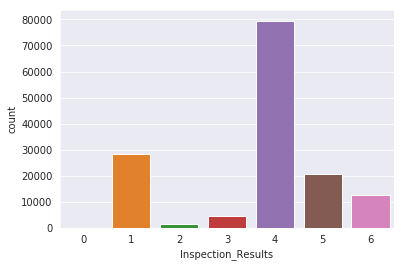

In [12]:
sns.countplot(train['Inspection_Results'])

# Data pre-processing

In [13]:
# Invalid dates
for dt in ['29-02-2011','29-02-2015']:
    print(dt, train[train['Date']==dt].shape)
    
for dt in ['29-02-2011','29-02-2015']:
    print(dt, test[test['Date']==dt].shape)

29-02-2011 (51, 15)
29-02-2015 (2, 15)
29-02-2011 (15, 14)
29-02-2015 (0, 14)


In [14]:
df = train.append(test, ignore_index=True, sort=False)
df.shape

(196591, 15)

In [15]:
df.head(2)

,ID,Date,LicenseNo,FacilityID,FacilityName,Type,Street,City,State,LocationID,Reason,SectionViolations,RiskLevel,Geo_Loc,Inspection_Results
0,31103489027986,26-04-2010,4744,8123,7715,RESTAURANT,15522,id-11235901,id_1890134,81876.0,CANVASS,33.0,High,locid16406,4.0
1,10088999935915,21-06-2009,2973,12268,11664,GROCERY STORE,3057,id-11235901,id_1890134,81862.0,COMPLAINT,33.0,High,locid878,4.0


In [16]:
def impute_mean(series):
    return series.fillna(series.mean())
df['SectionViolations'] = df.groupby(['Reason'])['SectionViolations'].transform(impute_mean)

In [17]:
df['RiskLevel'] = df['RiskLevel'].str.replace('Uncertain','High')

In [18]:
df['Date'] = df['Date'].str.replace('29-02-2011','28-02-2011')
df['Date'] = df['Date'].str.replace('29-02-2015','28-02-2011')

In [19]:
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y', errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['Dayofweek'] = df['Date'].dt.dayofweek
df['Dayofyear'] = df['Date'].dt.dayofyear
df['Week'] = df['Date'].dt.week 
df['Quarter'] = df['Date'].dt.quarter
df['Is_month_start'] = pd.to_datetime(df['Date']).dt.is_month_start 
df['Is_month_end'] = pd.to_datetime(df['Date']).dt.is_month_end 
df['Is_quarter_start'] = pd.to_datetime(df['Date']).dt.is_quarter_start
df['Is_quarter_end'] = pd.to_datetime(df['Date']).dt.is_quarter_end 
df['Is_year_start'] = pd.to_datetime(df['Date']).dt.is_year_start 
df['Is_year_end'] = pd.to_datetime(df['Date']).dt.is_year_end
#df['Semester'] = np.where(df['Quarter'].isin([1,2]),1,2)

In [20]:
for col in ['Type','City','State','LocationID','Reason','RiskLevel','LicenseNo']:
    df[col] = df[col].astype('category')

In [21]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['LicenseNo_enc'] = le.fit_transform(df['LicenseNo'])

In [22]:
calc = df.groupby(['LicenseNo'], axis=0).agg({'LicenseNo':[('op1', 'count')]}).reset_index() 
calc.columns = ['LicenseNo','LicenseNo Count']
df = df.merge(calc, on=['LicenseNo'], how='left')

calc = df.groupby(['FacilityID'], axis=0).agg({'FacilityID':[('op1', 'count')]}).reset_index() 
calc.columns = ['FacilityID','FacilityID Count']
df = df.merge(calc, on=['FacilityID'], how='left')

calc = df.groupby(['FacilityName'], axis=0).agg({'FacilityName':[('op1', 'count')]}).reset_index() 
calc.columns = ['FacilityName','FacilityName Count']
df = df.merge(calc, on=['FacilityName'], how='left')

calc = df.groupby(['Type'], axis=0).agg({'Type':[('op1', 'count')]}).reset_index() 
calc.columns = ['Type','Type Count']
df = df.merge(calc, on=['Type'], how='left')

calc = df.groupby(['Street'], axis=0).agg({'Street':[('op1', 'count')]}).reset_index()   
calc.columns = ['Street','Street Count']
df = df.merge(calc, on=['Street'], how='left')

calc = df.groupby(['City'], axis=0).agg({'City':[('op1', 'count')]}).reset_index()   
calc.columns = ['City','City Count']
df = df.merge(calc, on=['City'], how='left')

calc = df.groupby(['State'], axis=0).agg({'State':[('op1', 'count')]}).reset_index()   
calc.columns = ['State','State Count']
df = df.merge(calc, on=['State'], how='left')

calc = df.groupby(['LocationID'], axis=0).agg({'LocationID':[('op1', 'count')]}).reset_index() 
calc.columns = ['LocationID','LocationID Count']
df = df.merge(calc, on=['LocationID'], how='left')

calc = df.groupby(['Reason'], axis=0).agg({'Reason':[('op1', 'count')]}).reset_index() 
calc.columns = ['Reason','Reason Count']
df = df.merge(calc, on=['Reason'], how='left')

calc = df.groupby(['SectionViolations'], axis=0).agg({'SectionViolations':[('op1', 'count')]}).reset_index() 
calc.columns = ['SectionViolations','SectionViolations Count']
df = df.merge(calc, on=['SectionViolations'], how='left')

# RiskLevel

calc = df.groupby(['Geo_Loc'], axis=0).agg({'Geo_Loc':[('op1', 'count')]}).reset_index() 
calc.columns = ['Geo_Loc','Geo_Loc Count']
df = df.merge(calc, on=['Geo_Loc'], how='left')

In [23]:
calc = df.groupby(['Year'], axis=0).agg({'Year':[('op1', 'count')]}).reset_index() 
calc.columns = ['Year','Year Count']
df = df.merge(calc, on=['Year'], how='left')

In [24]:
agg_func = {
    'SectionViolations': ['mean','median','min','max','sum']    
}
agg_func = df.groupby('LicenseNo').agg(agg_func)
agg_func.columns = [ 'LicenseNo_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['LicenseNo'], how='left')

agg_func = {
    'SectionViolations': ['mean','median','min','max','sum']       
}
agg_func = df.groupby('LocationID').agg(agg_func)
agg_func.columns = [ 'LocationID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['LocationID'], how='left')

agg_func = {
    'SectionViolations': ['mean','median','min','max','sum']    
}
agg_func = df.groupby('Year').agg(agg_func)
agg_func.columns = [ 'Year_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year'], how='left')

In [25]:
agg_func = {
    'SectionViolations': ['mean','sum']
}
agg_func = df.groupby(['Date','FacilityID']).agg(agg_func)
agg_func.columns = [ 'Date_FacilityID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Date','FacilityID'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Date','FacilityName']).agg(agg_func)
agg_func.columns = [ 'Date_FacilityName_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Date','FacilityName'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Date','LocationID']).agg(agg_func)
agg_func.columns = [ 'Date_LocationID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Date','LocationID'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Date','Geo_Loc']).agg(agg_func)
agg_func.columns = [ 'Date_Geo_Loc_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Date','Geo_Loc'], how='left')

In [26]:
agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','FacilityID']).agg(agg_func)
agg_func.columns = [ 'Year_FacilityID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','FacilityID'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','FacilityName']).agg(agg_func)
agg_func.columns = [ 'Year_FacilityName_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','FacilityName'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','LocationID']).agg(agg_func)
agg_func.columns = [ 'Year_LocationID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','LocationID'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','Geo_Loc']).agg(agg_func)
agg_func.columns = [ 'Year_Geo_Loc_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','Geo_Loc'], how='left')

In [27]:
agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','Month','FacilityID']).agg(agg_func)
agg_func.columns = [ 'Year_Month_FacilityID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','Month','FacilityID'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','Month','FacilityName']).agg(agg_func)
agg_func.columns = [ 'Year_Month_FacilityName_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','Month','FacilityName'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','Month','LocationID']).agg(agg_func)
agg_func.columns = [ 'Year_Month_LocationID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','Month','LocationID'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','Month','Geo_Loc']).agg(agg_func)
agg_func.columns = [ 'Year_Month_Geo_Loc_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','Month','Geo_Loc'], how='left')

In [28]:
agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','Quarter','FacilityID']).agg(agg_func)
agg_func.columns = [ 'Year_Quarter_FacilityID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','Quarter','FacilityID'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','Quarter','FacilityName']).agg(agg_func)
agg_func.columns = [ 'Year_Quarter_FacilityName_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','Quarter','FacilityName'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','Quarter','LocationID']).agg(agg_func)
agg_func.columns = [ 'Year_Quarter_LocationID_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','Quarter','LocationID'], how='left')

agg_func = {
    'SectionViolations': ['mean','sum']    
}
agg_func = df.groupby(['Year','Quarter','Geo_Loc']).agg(agg_func)
agg_func.columns = [ 'Year_Quarter_Geo_Loc_' + ('_'.join(col).strip()) for col in agg_func.columns.values]
agg_func.reset_index(inplace=True)
df = df.merge(agg_func, on=['Year','Quarter','Geo_Loc'], how='left')

In [29]:
num_col = ['mean']
cat_col = ['count','nunique']
temp = df.groupby(['Date']).agg({'FacilityID': cat_col, 'FacilityName':cat_col, 'SectionViolations':num_col})
temp.columns = ['Date_' + '_'.join(col).strip() for col in temp.columns.values]
temp.reset_index(inplace=True)
df = df.merge(temp, on=['Date'], how='left')

In [30]:
temp = df.sort_values(by=['LicenseNo','Date'])
temp['License_next_violations'] = temp.groupby('LicenseNo')['SectionViolations'].shift(0) - temp.groupby('LicenseNo')['SectionViolations'].shift(-1)
temp['License_prev_violations'] = temp.groupby('LicenseNo')['SectionViolations'].shift(0) - temp.groupby('LicenseNo')['SectionViolations'].shift(1)
df = pd.merge(df, temp[['ID','License_next_violations', 'License_prev_violations']], on = 'ID', how = 'left')

temp = df.sort_values(by=['FacilityID','Date'])
temp['FacilityID_next_violations'] = temp.groupby('FacilityID')['SectionViolations'].shift(0) - temp.groupby('FacilityID')['SectionViolations'].shift(-1)
temp['FacilityID_prev_violations'] = temp.groupby('FacilityID')['SectionViolations'].shift(0) - temp.groupby('FacilityID')['SectionViolations'].shift(1)
df = pd.merge(df, temp[['ID','FacilityID_next_violations', 'FacilityID_prev_violations']], on = 'ID', how = 'left')

temp = df.sort_values(by=['FacilityName','Date'])
temp['FacilityName_next_violations'] = temp.groupby('FacilityName')['SectionViolations'].shift(0) - temp.groupby('FacilityName')['SectionViolations'].shift(-1)
temp['FacilityName_prev_violations'] = temp.groupby('FacilityName')['SectionViolations'].shift(0) - temp.groupby('FacilityName')['SectionViolations'].shift(1)
df = pd.merge(df, temp[['ID','FacilityName_next_violations', 'FacilityName_prev_violations']], on = 'ID', how = 'left')

In [31]:
temp  = df.sort_values(by = ['LicenseNo','Date']).set_index('Date')
res = temp.groupby('LicenseNo').rolling('90D')[['SectionViolations']].mean().reset_index(drop=True)
res.columns = [c + '_LicenseNo_Date_rolling' for c in res.columns]
res['ID'] = temp['ID'].values
df = pd.merge(df, res, on = 'ID', how='left')

In [32]:
agg_func = df.groupby(['Year','FacilityID'])['Reason'].apply(lambda x: x.mode()[0])
agg_func = agg_func.reset_index()
agg_func.columns = ['Year','FacilityID','Year_FacilityID_Reason_mode']
df = df.merge(agg_func, on=['Year','FacilityID'], how='left')
df['Year_FacilityID_Reason_mode'] = df['Year_FacilityID_Reason_mode'].astype('category')

In [33]:
temp = df.sort_values(by=['FacilityID', 'Date'])
temp[['Prev_SectionViolations_ByFacilityID']] = temp.groupby('FacilityID')[['SectionViolations']].shift(-1)
df = pd.merge(df, temp[['ID', 'Prev_SectionViolations_ByFacilityID']], on = 'ID', how = 'left')

temp = df.sort_values(by=['FacilityName', 'Date'])
temp[['Prev_SectionViolations_ByFacilityName']] = temp.groupby('FacilityName')[['SectionViolations']].shift(-1)
df = pd.merge(df, temp[['ID', 'Prev_SectionViolations_ByFacilityName']], on = 'ID', how = 'left')

temp = df.sort_values(by=['LicenseNo', 'Date'])
temp[['Prev_SectionViolations_ByLicenseNo']] = temp.groupby('LicenseNo')[['SectionViolations']].shift(-1)
df = pd.merge(df, temp[['ID', 'Prev_SectionViolations_ByLicenseNo']], on = 'ID', how = 'left')

In [34]:
temp = df.sort_values(by=['FacilityID', 'Date'])
temp[['Prev_SectionViolations_ByFacilityID2']] = temp.groupby('FacilityID')[['SectionViolations']].shift(-2)
df = pd.merge(df, temp[['ID', 'Prev_SectionViolations_ByFacilityID2']], on = 'ID', how = 'left')

temp = df.sort_values(by=['FacilityName', 'Date'])
temp[['Prev_SectionViolations_ByFacilityName2']] = temp.groupby('FacilityName')[['SectionViolations']].shift(-2)
df = pd.merge(df, temp[['ID', 'Prev_SectionViolations_ByFacilityName2']], on = 'ID', how = 'left')

temp = df.sort_values(by=['LicenseNo', 'Date'])
temp[['Prev_SectionViolations_ByLicenseNo2']] = temp.groupby('LicenseNo')[['SectionViolations']].shift(-2)
df = pd.merge(df, temp[['ID', 'Prev_SectionViolations_ByLicenseNo2']], on = 'ID', how = 'left')

In [35]:
df['FacilityID_Year_SecViolations_rank'] = df.groupby(['FacilityID','Year'])["SectionViolations"].rank()
df['FacilityName_Year_SecViolations_rank'] = df.groupby(['FacilityName','Year'])["SectionViolations"].rank()
df['LicenseNo_Year_SecViolations_rank'] = df.groupby(['LicenseNo','Year'])["SectionViolations"].rank()

df['FacilityID_YearMonth_SecViolations_rank'] = df.groupby(['FacilityID','Year','Month'])["SectionViolations"].rank()
df['FacilityName_YearMonth_SecViolations_rank'] = df.groupby(['FacilityName','Year','Month'])["SectionViolations"].rank()
df['LicenseNo_YearMonth_SecViolations_rank'] = df.groupby(['LicenseNo','Year','Month'])["SectionViolations"].rank()

df['FacilityID_Quarter_SecViolations_rank'] = df.groupby(['FacilityID','Quarter'])["SectionViolations"].rank()
df['FacilityName_Quarter_SecViolations_rank'] = df.groupby(['FacilityName','Quarter'])["SectionViolations"].rank()
df['LicenseNo_Quarter_SecViolations_rank'] = df.groupby(['LicenseNo','Quarter'])["SectionViolations"].rank()

In [36]:
temp = df.groupby(['LocationID'])["FacilityID"].agg(['size']).reset_index()
temp.columns = ["LocationID", "LocationID_FacilityID_count"]
df = df.merge(temp, on=["LocationID"], how="left")

temp = df.groupby(['Geo_Loc'])["FacilityID"].agg(['size']).reset_index()
temp.columns = ["Geo_Loc", "Geo_Loc_FacilityID_count"]
df = df.merge(temp, on=["Geo_Loc"], how="left")

In [37]:
################ removed these features after looking at feature importances
df.drop(['City','City Count','State','State Count'], axis=1, inplace=True)  
df.drop(['Quarter','Is_month_start','Is_month_end','Is_quarter_start','Is_quarter_end','Is_year_start','Is_year_end'], axis=1, inplace=True)
df.drop(['Year_SectionViolations_min','LocationID_SectionViolations_min'], axis=1, inplace=True)    
################

In [38]:
df.drop(['ID','Date','LicenseNo','Street','Geo_Loc'], axis=1, inplace=True)

In [39]:
df.head(2)

,FacilityID,FacilityName,Type,LocationID,Reason,SectionViolations,RiskLevel,Inspection_Results,Year,Month,Day,Dayofweek,Dayofyear,Week,LicenseNo_enc,LicenseNo Count,FacilityID Count,FacilityName Count,Type Count,Street Count,LocationID Count,Reason Count,SectionViolations Count,Geo_Loc Count,Year Count,LicenseNo_SectionViolations_mean,LicenseNo_SectionViolations_median,LicenseNo_SectionViolations_min,LicenseNo_SectionViolations_max,LicenseNo_SectionViolations_sum,LocationID_SectionViolations_mean,LocationID_SectionViolations_median,LocationID_SectionViolations_max,LocationID_SectionViolations_sum,Year_SectionViolations_mean,Year_SectionViolations_median,Year_SectionViolations_max,Year_SectionViolations_sum,Date_FacilityID_SectionViolations_mean,Date_FacilityID_SectionViolations_sum,Date_FacilityName_SectionViolations_mean,Date_FacilityName_SectionViolations_sum,Date_LocationID_SectionViolations_mean,Date_LocationID_SectionViolations_sum,Date_Geo_Loc_SectionViolations_mean,Date_Geo_Loc_SectionViolations_sum,Year_FacilityID_SectionViolations_mean,Year_FacilityID_SectionViolations_sum,Year_FacilityName_SectionViolations_mean,Year_FacilityName_SectionViolations_sum,Year_LocationID_SectionViolations_mean,Year_LocationID_SectionViolations_sum,Year_Geo_Loc_SectionViolations_mean,Year_Geo_Loc_SectionViolations_sum,Year_Month_FacilityID_SectionViolations_mean,Year_Month_FacilityID_SectionViolations_sum,Year_Month_FacilityName_SectionViolations_mean,Year_Month_FacilityName_SectionViolations_sum,Year_Month_LocationID_SectionViolations_mean,Year_Month_LocationID_SectionViolations_sum,Year_Month_Geo_Loc_SectionViolations_mean,Year_Month_Geo_Loc_SectionViolations_sum,Year_Quarter_FacilityID_SectionViolations_mean,Year_Quarter_FacilityID_SectionViolations_sum,Year_Quarter_FacilityName_SectionViolations_mean,Year_Quarter_FacilityName_SectionViolations_sum,Year_Quarter_LocationID_SectionViolations_mean,Year_Quarter_LocationID_SectionViolations_sum,Year_Quarter_Geo_Loc_SectionViolations_mean,Year_Quarter_Geo_Loc_SectionViolations_sum,Date_FacilityID_count,Date_FacilityID_nunique,Date_FacilityName_count,Date_FacilityName_nunique,Date_SectionViolations_mean,License_next_violations,License_prev_violations,FacilityID_next_violations,FacilityID_prev_violations,FacilityName_next_violations,FacilityName_prev_violations,SectionViolations_LicenseNo_Date_rolling,Year_FacilityID_Reason_mode,Prev_SectionViolations_ByFacilityID,Prev_SectionViolations_ByFacilityName,Prev_SectionViolations_ByLicenseNo,Prev_SectionViolations_ByFacilityID2,Prev_SectionViolations_ByFacilityName2,Prev_SectionViolations_ByLicenseNo2,FacilityID_Year_SecViolations_rank,FacilityName_Year_SecViolations_rank,LicenseNo_Year_SecViolations_rank,FacilityID_YearMonth_SecViolations_rank,FacilityName_YearMonth_SecViolations_rank,LicenseNo_YearMonth_SecViolations_rank,FacilityID_Quarter_SecViolations_rank,FacilityName_Quarter_SecViolations_rank,LicenseNo_Quarter_SecViolations_rank,LocationID_FacilityID_count,Geo_Loc_FacilityID_count
0,8123,7715,RESTAURANT,81876.0,CANVASS,33.0,High,4.0,2010,4,26,0,116,17,4744,15,15,15,131182.0,15,1471.0,104077,17447.0,15,18670,27.510233,31.0,3.0,43.0,412.653502,23.970120,25.828985,60.0,35092.255092,25.430004,28.132267,70.0,474752.750339,33.0,33.0,33.0,33.0,29.414492,58.828985,33.0,33.0,33.0,33.0,33.0,33.0,27.282012,3601.225525,33.0,33.0,33.0,33.0,33.0,33.0,31.130852,249.046819,33.0,33.0,33.0,33.0,33.0,33.0,29.154855,1107.884498,33.0,33.0,66,63,66,61,25.732506,8.782166,1.0,8.782166,1.0,8.782166,1.0,33.0,CANVASS,24.217834,24.217834,24.217834,33.0,33.0,33.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,5.0,5.0,1471.0,15
1,12268,11664,GROCERY STORE,81862.0,COMPLAINT,33.0,High,4.0,2009,6,21,6,172,25,2973,27,27,27,25012.0,27,3687.0,18214,17447.0,27,17820,29.894855,33.0,1.0,55.0,807.161089,25.093064,28.132267,58.0,92166.825229,25.235058,26.878013,70.0,442118.221643,33.0,33.0,33.0,33.0,22.072611,66.217834,33.0,33.0,33.5,67.0,33.5,67.0,25.501777,8925.621780,33.5,67.0,33.0,33.0,33.0,33.0,

In [40]:
train_df = df[df['Inspection_Results'].isnull()!=True]
test_df = df[df['Inspection_Results'].isnull()==True]
test_df.drop('Inspection_Results', axis=1, inplace=True)

In [41]:
train_df.shape, test_df.shape

((147443, 100), (49148, 99))

In [42]:
X = train_df.drop(labels=['Inspection_Results'], axis=1)
y = train_df['Inspection_Results'].values

# Train test split

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [44]:
X_train.shape, y_train.shape, X_cv.shape, y_cv.shape

((110582, 99), (110582,), (36861, 99), (36861,))

In [45]:
X_train.tail(2)

,FacilityID,FacilityName,Type,LocationID,Reason,SectionViolations,RiskLevel,Year,Month,Day,Dayofweek,Dayofyear,Week,LicenseNo_enc,LicenseNo Count,FacilityID Count,FacilityName Count,Type Count,Street Count,LocationID Count,Reason Count,SectionViolations Count,Geo_Loc Count,Year Count,LicenseNo_SectionViolations_mean,LicenseNo_SectionViolations_median,LicenseNo_SectionViolations_min,LicenseNo_SectionViolations_max,LicenseNo_SectionViolations_sum,LocationID_SectionViolations_mean,LocationID_SectionViolations_median,LocationID_SectionViolations_max,LocationID_SectionViolations_sum,Year_SectionViolations_mean,Year_SectionViolations_median,Year_SectionViolations_max,Year_SectionViolations_sum,Date_FacilityID_SectionViolations_mean,Date_FacilityID_SectionViolations_sum,Date_FacilityName_SectionViolations_mean,Date_FacilityName_SectionViolations_sum,Date_LocationID_SectionViolations_mean,Date_LocationID_SectionViolations_sum,Date_Geo_Loc_SectionViolations_mean,Date_Geo_Loc_SectionViolations_sum,Year_FacilityID_SectionViolations_mean,Year_FacilityID_SectionViolations_sum,Year_FacilityName_SectionViolations_mean,Year_FacilityName_SectionViolations_sum,Year_LocationID_SectionViolations_mean,Year_LocationID_SectionViolations_sum,Year_Geo_Loc_SectionViolations_mean,Year_Geo_Loc_SectionViolations_sum,Year_Month_FacilityID_SectionViolations_mean,Year_Month_FacilityID_SectionViolations_sum,Year_Month_FacilityName_SectionViolations_mean,Year_Month_FacilityName_SectionViolations_sum,Year_Month_LocationID_SectionViolations_mean,Year_Month_LocationID_SectionViolations_sum,Year_Month_Geo_Loc_SectionViolations_mean,Year_Month_Geo_Loc_SectionViolations_sum,Year_Quarter_FacilityID_SectionViolations_mean,Year_Quarter_FacilityID_SectionViolations_sum,Year_Quarter_FacilityName_SectionViolations_mean,Year_Quarter_FacilityName_SectionViolations_sum,Year_Quarter_LocationID_SectionViolations_mean,Year_Quarter_LocationID_SectionViolations_sum,Year_Quarter_Geo_Loc_SectionViolations_mean,Year_Quarter_Geo_Loc_SectionViolations_sum,Date_FacilityID_count,Date_FacilityID_nunique,Date_FacilityName_count,Date_FacilityName_nunique,Date_SectionViolations_mean,License_next_violations,License_prev_violations,FacilityID_next_violations,FacilityID_prev_violations,FacilityName_next_violations,FacilityName_prev_violations,SectionViolations_LicenseNo_Date_rolling,Year_FacilityID_Reason_mode,Prev_SectionViolations_ByFacilityID,Prev_SectionViolations_ByFacilityName,Prev_SectionViolations_ByLicenseNo,Prev_SectionViolations_ByFacilityID2,Prev_SectionViolations_ByFacilityName2,Prev_SectionViolations_ByLicenseNo2,FacilityID_Year_SecViolations_rank,FacilityName_Year_SecViolations_rank,LicenseNo_Year_SecViolations_rank,FacilityID_YearMonth_SecViolations_rank,FacilityName_YearMonth_SecViolations_rank,LicenseNo_YearMonth_SecViolations_rank,FacilityID_Quarter_SecViolations_rank,FacilityName_Quarter_SecViolations_rank,LicenseNo_Quarter_SecViolations_rank,LocationID_FacilityID_count,Geo_Loc_FacilityID_count
49072,20654,19754,RESTAURANT,81870.0,CANVASS,16.0,High,2016,6,22,2,174,25,22736,7,9,9,131182.0,11,5459.0,104077,3257.0,11,21579,17.404141,16.000000,3.0,32.0,121.828985,23.667632,24.217834,58.0,129201.603624,25.164568,28.132267,45.0,543026.215297,16.0,16.0,16.0,16.0,26.226453,131.132267,16.0,16.0,24.000000,48.000000,24.000000,48.000000,24.440359,17743.700772,24.000000,48.000000,24.0,48.0,24.0,48.0,25.470924,2750.859769,24.0,48.0,24.0,48.0,24.0,48.0,24.372576,5508.202066,24.0,48.0,126,118,126,117,25.464503,-16.000000,4.0,-16.000000,4.0,-16.000000,4.0,16.0,CANVASS,32.000000,32.000000,32.000000,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,5459.0,11
21854,8493,8062,RESTAURANT,81848.0,COMPLAINT RE-INSPECTION,30.0,High,2017,1,17,1,17,3,25793,10,14,14,131182.0,28,1896.0,7577,9502.0,28,17188,24.321783,27.108917,11.0,33.0,243.217834,24.805537,26.094359,58.0,46981.687991,18.857346,21.884222,60.0,324120.063649,30.0,30.0,30.0,30.0,30.000000,30.000000,30.0,30.0,23.405945,70.217834,23.405945,70.

# Build the model

In [46]:
from sklearn.metrics import log_loss

In [47]:
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_cv, label=y_cv)

param = {'objective': 'multiclass',
         'num_class': 7,
         'boosting': 'gbdt',  
         'metric': 'multi_logloss',
         'learning_rate': 0.01, 
         'num_iterations': 2000,
         'num_leaves': 100,
         'max_depth': -1,
         'min_data_in_leaf': 15,
         'bagging_fraction':0.9,
         'bagging_freq': 1,
         'feature_fraction': 0.7,
         'lambda_l2': 0.8,
         'min_data_per_group': 75,
         'max_bin': 255,
         'is_unbalance':True
         }

clf = lgb.train(params=param, 
                early_stopping_rounds=200,
                verbose_eval=100,
                train_set=train_data,
                valid_sets=[test_data])

y_pred = clf.predict(X_cv)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 0.505046
[200]	valid_0's multi_logloss: 0.300239
[300]	valid_0's multi_logloss: 0.224035
[400]	valid_0's multi_logloss: 0.192752
[500]	valid_0's multi_logloss: 0.178164
[600]	valid_0's multi_logloss: 0.170683
[700]	valid_0's multi_logloss: 0.166311
[800]	valid_0's multi_logloss: 0.163602
[900]	valid_0's multi_logloss: 0.161813
[1000]	valid_0's multi_logloss: 0.160637
[1100]	valid_0's multi_logloss: 0.160007
[1200]	valid_0's multi_logloss: 0.15964
[1300]	valid_0's multi_logloss: 0.159462
[1400]	valid_0's multi_logloss: 0.159541
[1500]	valid_0's multi_logloss: 0.159837
Early stopping, best iteration is:
[1310]	valid_0's multi_logloss: 0.159439


In [48]:
log_loss(y_cv, y_pred)

0.15943881845468275

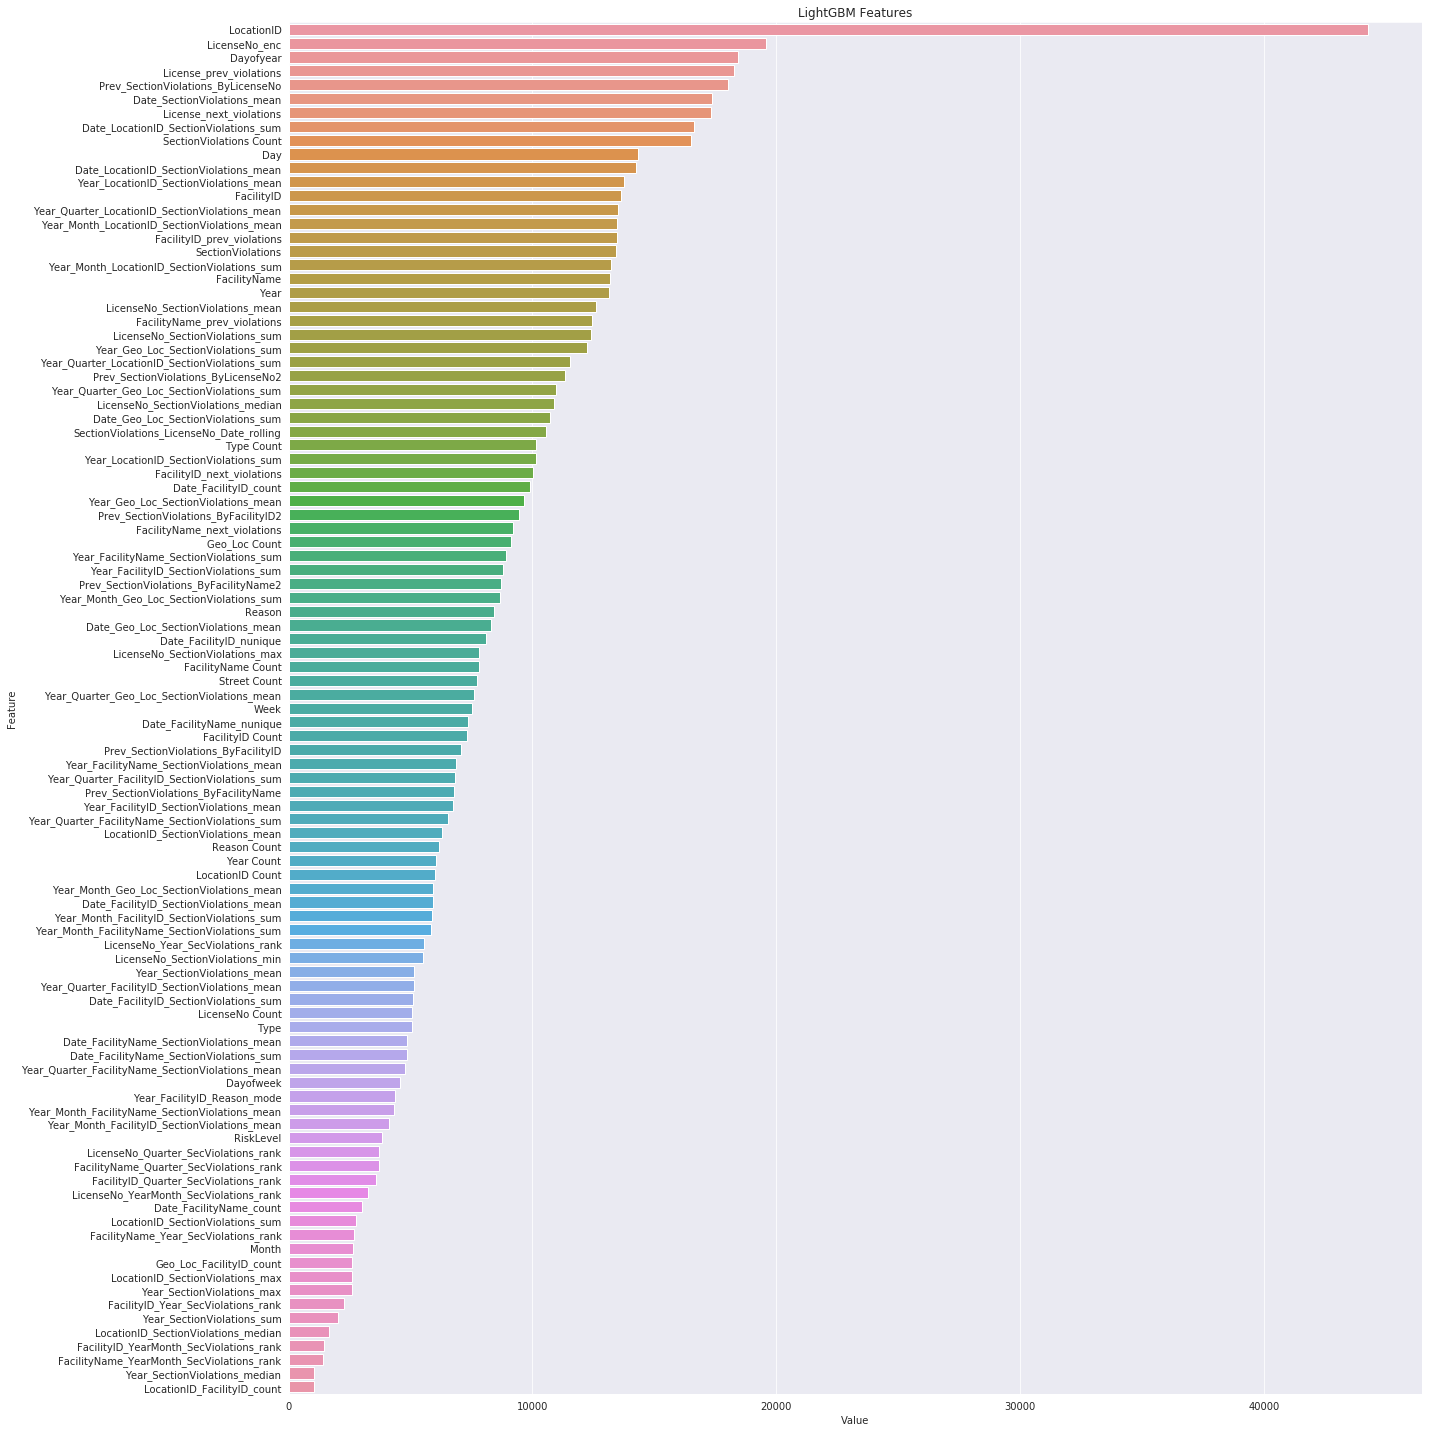

In [49]:
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importance(), X.columns), reverse=True)[:], columns=['Value','Feature'])
plt.figure(figsize=(20,20))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [50]:
feature_imp.loc[feature_imp.Value >= 0].sort_values(by=['Value'], ascending = False)

,Value,Feature
0,44261,LocationID
1,19583,LicenseNo_enc
2,18420,Dayofyear
3,18248,License_prev_violations
4,18034,Prev_SectionViolations_ByLicenseNo
5,17372,Date_SectionViolations_mean
6,17332,License_next_violations
7,16620,Date_LocationID_SectionViolations_sum
8,16493,SectionViolations Count
9,14334,Day


# Predict on test set

In [51]:
Xtest = test_df

In [52]:
from sklearn.model_selection import KFold, StratifiedKFold

errlgb = []
y_pred_totlgb = []

fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=123456789)

for train_index, test_index in fold.split(X, y):
    
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)
    
    clf = lgb.train(params=param, 
                     early_stopping_rounds=200,
                     verbose_eval=100,
                     train_set=train_data,
                     valid_sets=[test_data])

    y_pred = clf.predict(X_test)
    print("Log Loss: ", (log_loss(y_test, y_pred)))
    
    errlgb.append(log_loss(y_test, y_pred))
    p = clf.predict(Xtest)
    y_pred_totlgb.append(p)

Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 0.506269
[200]	valid_0's multi_logloss: 0.301334
[300]	valid_0's multi_logloss: 0.224753
[400]	valid_0's multi_logloss: 0.193063
[500]	valid_0's multi_logloss: 0.178262
[600]	valid_0's multi_logloss: 0.170441
[700]	valid_0's multi_logloss: 0.165768
[800]	valid_0's multi_logloss: 0.162728
[900]	valid_0's multi_logloss: 0.160745
[1000]	valid_0's multi_logloss: 0.159397
[1100]	valid_0's multi_logloss: 0.158576
[1200]	valid_0's multi_logloss: 0.157953
[1300]	valid_0's multi_logloss: 0.157617
[1400]	valid_0's multi_logloss: 0.157546
[1500]	valid_0's multi_logloss: 0.157599
Early stopping, best iteration is:
[1379]	valid_0's multi_logloss: 0.157514
Log Loss:  0.15751412459938854
Training until validation scores don't improve for 200 rounds
[100]	valid_0's multi_logloss: 0.502235
[200]	valid_0's multi_logloss: 0.295672
[300]	valid_0's multi_logloss: 0.218616
[400]	valid_0's multi_logloss: 0.186727
[50

In [53]:
np.mean(errlgb,0)

0.15458214364290573

In [54]:
sub.columns

Index(['FACILITY CHANGED', 'FAIL', 'FURTHER INSPECTION REQUIRED',
       'INSPECTION OVERRULED', 'PASS', 'PASS(CONDITIONAL)', 'SHUT-DOWN'],
      dtype='object')

In [55]:
y_pred = np.mean(y_pred_totlgb,0)

In [56]:
submission = pd.DataFrame(data=y_pred, columns=sub.columns)
submission.head()

,FACILITY CHANGED,FAIL,FURTHER INSPECTION REQUIRED,INSPECTION OVERRULED,PASS,PASS(CONDITIONAL),SHUT-DOWN
0,2.893741e-06,0.990414,0.000060,0.001509,0.000612,0.007319,0.000083
1,4.853035e-07,0.001998,0.000003,0.000008,0.997702,0.000268,0.000020
2,2.300672e-05,0.003450,0.000098,0.958360,0.034688,0.001031,0.002350
3,1.241672e-05,0.011191,0.000008,0.000039,0.031950,0.001183,0.955617
4,4.967000e-07,0.000272,0.000003,0.000010,0.999179,0.000510,0.000026


In [57]:
submission.to_excel('Output.xlsx', index=False)